# やってみよう

In [1]:
# # Googleドライブのマウント（Colab使いのみ）

# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/dlc/week2

In [2]:
# 図表が使えるようにする

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Dataset : データを一つのデータベースにまとめる

In [3]:
# MNISTをインポートする

from torchvision import datasets, transforms

train_Dataset = datasets.MNIST(
    './data'
    , train=True
    , download=True 
    , transform=transforms.ToTensor()
)

test_dataset = datasets.MNIST(
    './data'
    , train=False
    , transform=transforms.ToTensor()
)

In [4]:
# 数を確認

print('train_Dataset size: ', len(train_Dataset))  
print('test_dataset size: ', len(test_dataset))

train_Dataset size:  60000
test_dataset size:  10000


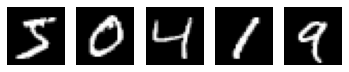

In [5]:
# データを確認してみる

plot_num = 5

fig, axes = plt.subplots(1, plot_num)
for i in range(plot_num):
    axes[i].imshow(train_Dataset[i][0].view(-1, 28), cmap='gray')
    axes[i].set_axis_off()

In [6]:
# 学習データと検証データの分割

import torch 

train_dataset, valid_dataset = torch.utils.data.random_split(
    train_Dataset
    , [50000, 10000]
)

In [7]:
# 数を確認

print('train_dataset size: ', len(train_dataset)) 
print('valid_dataset size: ', len(valid_dataset)) 
print('test_dataset size: ', len(test_dataset))

train_dataset size:  50000
valid_dataset size:  10000
test_dataset size:  10000


DataLoader : データをミニバッチ単位で取り出す 

In [8]:
# ミニバッチごとに取り出す

from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=batch_size 
    , shuffle=True
)

valid_loader = DataLoader(
    dataset=valid_dataset
    , batch_size=batch_size 
    , shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=batch_size
    , shuffle=False
)

In [9]:
# ネットワークの定義

import torch.nn as nn
import torch.nn.functional as F

# クラス数
num_classes = 10

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28*1, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# デバイスに転送

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP().to(device)

In [11]:
# ネットワークの構造を確認

print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [12]:
# 損失関数と最適化手法を設定

import torch.optim as optim

# 損失関数: 交差エントロピー
criterion = nn.CrossEntropyLoss()

# 最適化手法: 確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=0.01)

1エポックの訓練を行う関数

- `net.train()` : trainモードに変換
- `optimizer.zero_grad()` : 勾配を0にリセットする（勾配はbackwardメソッドが実行されるたびに積算されるため必要）
- `outputs` : 順伝搬の出力を計算
- `loss` : 出力とミニバッチのラベルからコスト関数を計算
- `loss.backward()` : lossの勾配を計算
- `optimizer.step()` : パラメータを更新

In [13]:
# 1エポックの訓練を行う関数を定義

def train1Epoch(model, optimizer, criterion, dataloader, device):
    # 学習モードに切り替え
    model.train()
    train_loss, train_acc = 0, 0

    # ミニバッチ回数実行
    for i, (images, labels) in enumerate(dataloader):
        # viewで28x28x1を1次元配列に変換し、deviceへ転送
        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        # 勾配をリセット
        optimizer.zero_grad()
        # 順伝搬の計算
        outputs = model(images)
        # lossの計算
        loss = criterion(outputs, labels)
        # accの計算
        acc = (outputs.max(1)[1] == labels).sum()
        train_acc += acc.item()
        # 逆伝搬の計算
        loss.backward()
        # 重みの更新
        optimizer.step()
        # lossのミニバッチ分を加算
        train_loss += loss.item()

    # lossとaccの平均を計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    return avg_train_loss, avg_train_acc

推論するための関数

- `net.eval()` : networkを評価モードに変換
- `with torch.no_grad()` : 逆伝搬が必要ないので余計な勾配計算を回避
- `outputs` : 予測値を計算

In [14]:
# 推論するための関数を定義

def inference(model, optimizer, criterion, dataloader, device):
    # 評価モードに切り替え
    model.eval()
    test_loss, test_acc = 0, 0

    # 評価するとき勾配を計算しないように加える
    with torch.no_grad():
        for j, (images, labels) in enumerate(test_loader):
            images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            acc = (outputs.max(1)[1] == labels).sum()
            test_acc += acc.item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    avg_test_acc = test_acc / len(test_loader.dataset)

    return avg_test_loss, avg_test_acc

In [15]:
# 学習を行う関数の定義

def run(num_epochs, optimizer, criterion, device):
    train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss, train_acc = train1Epoch(model, optimizer, criterion, train_loader, device)
        valid_loss, valid_acc = inference(model, optimizer, criterion, valid_loader, device)

        print ('Epoch [{}/{}], Loss: {loss:.4f}, valid_loss: {valid_loss:.4f}, valid_acc: {valid_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=train_loss, valid_loss=valid_loss, valid_acc=valid_acc))
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [16]:
# 学習の実行

epoch = 20
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = run(epoch, optimizer, criterion, device)

Epoch [1/20], Loss: 0.0346, valid_loss: 0.0133, valid_acc: 0.8864
Epoch [2/20], Loss: 0.0117, valid_loss: 0.0100, valid_acc: 0.9095
Epoch [3/20], Loss: 0.0096, valid_loss: 0.0089, valid_acc: 0.9195
Epoch [4/20], Loss: 0.0084, valid_loss: 0.0080, valid_acc: 0.9262
Epoch [5/20], Loss: 0.0074, valid_loss: 0.0070, valid_acc: 0.9356
Epoch [6/20], Loss: 0.0066, valid_loss: 0.0065, valid_acc: 0.9404
Epoch [7/20], Loss: 0.0059, valid_loss: 0.0057, valid_acc: 0.9483
Epoch [8/20], Loss: 0.0054, valid_loss: 0.0051, valid_acc: 0.9511
Epoch [9/20], Loss: 0.0048, valid_loss: 0.0049, valid_acc: 0.9550
Epoch [10/20], Loss: 0.0044, valid_loss: 0.0044, valid_acc: 0.9588
Epoch [11/20], Loss: 0.0040, valid_loss: 0.0042, valid_acc: 0.9602
Epoch [12/20], Loss: 0.0037, valid_loss: 0.0039, valid_acc: 0.9628
Epoch [13/20], Loss: 0.0034, valid_loss: 0.0038, valid_acc: 0.9635
Epoch [14/20], Loss: 0.0032, valid_loss: 0.0036, valid_acc: 0.9653
Epoch [15/20], Loss: 0.0029, valid_loss: 0.0033, valid_acc: 0.9688
Epoc

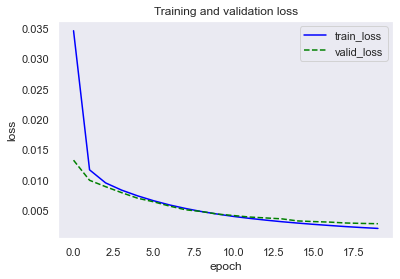

In [17]:
# lossの推移をplot

plt.figure()
plt.plot(range(epoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(epoch), valid_loss_list, color='green', linestyle='--', label='valid_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid() 

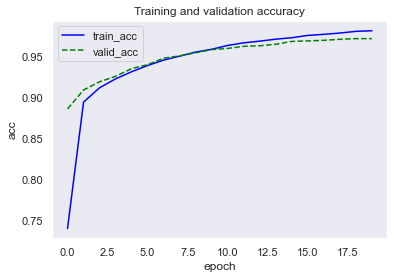

In [18]:
# accの推移をplot

plt.figure()
plt.plot(range(epoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(epoch), valid_acc_list, color='green', linestyle='--', label='valid_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

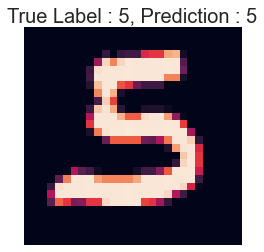

In [27]:
# 学習結果を確認

# datasetからサンプルを一つ取り出す
image, label = train_dataset[0]
sample = train_dataset[0][0].view(-1, 28*28).to(device)

# 学習後のモデルで予測
prediction_label = torch.argmax(model(sample))

fig, ax = plt.subplots()
ax.imshow(sample.to('cpu').detach().numpy().reshape(28, 28))
ax.axis('off')
ax.set_title(f'True Label : {label}, Prediction : {prediction_label}', fontsize=20)
plt.show()

In [28]:
# テストデータでAccを確認

model.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        outputs = model(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 

test_accuracy: 97.22 %


In [29]:
# 学習済みの重みとバイアスを保存

torch.save(model.state_dict(), 'mnist_model.ckpt')

In [ ]:
# クラス数
num_classes = 10

# Multi Layer Perceptron Network
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28*1, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP().to(device)
 
# optimizing
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

###  training
print ('training start ...')
num_epochs = 50   
 
# initialize list for plot graph after training
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = [], [], [], []
 
for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, valid_loss, valid_acc = 0, 0, 0, 0
    
    # ======== train_mode ======
    model.train()
    for i, (images, labels) in enumerate(train_loader):  # ミニバッチ回数実行
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        optimizer.zero_grad()  # 勾配リセット
        outputs = model(images)  # 順伝播の計算
        loss = criterion(outputs, labels)  # lossの計算
        train_loss += loss.item()  # train_loss に結果を蓄積
        acc = (outputs.max(1)[1] == labels).sum()  #  予測とラベルが合っている数の合計
        train_acc += acc.item()  # train_acc に結果を蓄積
        loss.backward()  # 逆伝播の計算        
        optimizer.step()  # 重みの更新
        avg_train_loss = train_loss / len(train_loader.dataset)  # lossの平均を計算
        avg_train_acc = train_acc / len(train_loader.dataset)  # accの平均を計算

    
    # ======== valid_mode ======
    model.eval()
    with torch.no_grad():  # 必要のない計算を停止
      for images, labels in valid_loader:        
          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          valid_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          valid_acc += acc.item()
    avg_valid_loss = valid_loss / len(valid_loader.dataset)
    avg_valid_acc = valid_acc / len(valid_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {valid_loss:.4f}, val_acc: {valid_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, valid_loss=avg_valid_loss, valid_acc=avg_valid_acc))
 
    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    valid_loss_list.append(avg_valid_loss)
    valid_acc_list.append(avg_valid_acc)
    
# ======== fainal test ======
model.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        outputs = model(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 
 
# save weights
torch.save(model.state_dict(), 'mnist_model.ckpt')
 
# plot graph 
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), valid_loss_list, color='green', linestyle='--', label='valid_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
 
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), valid_acc_list, color='green', linestyle='--', label='valid_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()